# Predicting lung cancer survival time

This challenge is a supervised survival prediction problem: predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data. In my approach, I focused mainly on the features extracted from the images but an other perspective would be to use the actual images to make our predictions and compare the results.

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

The dataset is split into 2 subsets : one for the training and one for the testing. The structure is the same for both : one file for the clinical data, one for the radiomics data and one for the output values, which is not given for the test subset obviously.  
We are going to take a look at both datasets (clinical & radiomics) from the training subset, clean up the data and see the information we can get.

## Clinical data

In [2]:
train_clinical = pd.read_csv("data/train/features/clinical_data.csv")
print(train_clinical.shape)
train_clinical.head()

(300, 7)


,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


The data is composed of 300 lines and 7 columns.

In [3]:
train_clinical.isnull().sum(axis = 0)

PatientID         0
Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

In [4]:
print(train_clinical['Histology'].value_counts())

Adenocarcinoma                         80
large cell                             61
squamous cell carcinoma                59
nos                                    38
adenocarcinoma                         21
Squamous cell carcinoma                19
NSCLC NOS (not otherwise specified)     2
Name: Histology, dtype: int64


We can see that values are missing for both *Histology* and _age_ features.  For the _age_ feature we will replace the missing values by the mean, but for the _Histology_ feature I would rather not take it into account since I'm afraid of interpreting it wrongly. If I had to use it however, I would probably clean up the duplicates and change the NaN values by NOS (not otherwise specified).  
I confirmed that for each row the PatientID matches the one of the other dataset so we can safely disregard this feature. I also didn't take into account the dataset from which the patient was from.

In [5]:
train_clinical.drop(columns = ["Histology", "PatientID", "SourceDataset"], inplace = True)
train_clinical["age"].fillna(train_clinical["age"].mean(), inplace=True)
train_clinical.head()

,Mstage,Nstage,Tstage,age
0,0,0,2,66.0000
1,0,2,4,64.5722
2,0,3,2,66.0452
3,0,2,3,59.3566
4,0,3,4,71.0554


In [6]:
train_clinical.describe()

,Mstage,Nstage,Tstage,age
count,300.000000,300.000000,300.000000,300.000000
mean,0.040000,0.963333,2.103333,68.766856
std,0.314212,1.160378,1.072297,9.327554
min,0.000000,0.000000,1.000000,42.513300
25%,0.000000,0.000000,1.000000,63.117525
50%,0.000000,0.000000,2.000000,69.000000
75%,0.000000,2.000000,3.000000,75.942475
max,3.000000,3.000000,5.000000,87.126600


### Visualisation

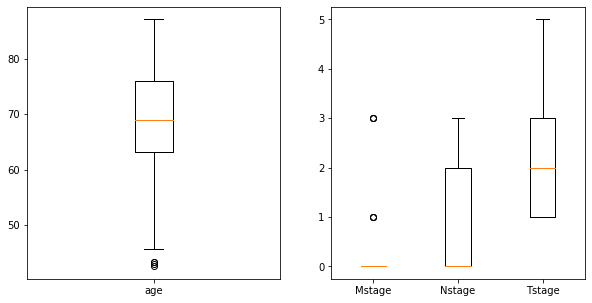

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))

axs[0].boxplot(train_clinical["age"], labels = ["age"])
axs[1].boxplot(train_clinical[["Mstage", "Nstage", "Tstage"]].values, labels = ["Mstage", "Nstage", "Tstage"])
plt.show()

Looks like **_Mstage_** is 0 most of the time so the variance is very low. We will drop features with low variance such as this one later on.

## Radiomics data

In [8]:
train_radiomics = pd.read_csv("data/train/features/radiomics.csv", dtype ='float64', skiprows = [0, 2], usecols = range(1,54))
print(train_radiomics.shape)
train_radiomics.head()

(300, 53)


,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


300 lines (like the other dataset) and 53 columns.

In [9]:
train_radiomics.isnull().sum(axis = 0)

original_shape_Compactness1                     0
original_shape_Compactness2                     0
original_shape_Maximum3DDiameter                0
original_shape_SphericalDisproportion           0
original_shape_Sphericity                       0
original_shape_SurfaceArea                      0
original_shape_SurfaceVolumeRatio               0
original_shape_VoxelVolume                      0
original_firstorder_Energy                      0
original_firstorder_Entropy                     0
original_firstorder_Kurtosis                    0
original_firstorder_Maximum                     0
original_firstorder_Mean                        0
original_firstorder_MeanAbsoluteDeviation       0
original_firstorder_Median                      0
original_firstorder_Minimum                     0
original_firstorder_Range                       0
original_firstorder_RootMeanSquared             0
original_firstorder_Skewness                    0
original_firstorder_StandardDeviation           0


No missing values.

In [10]:
train_radiomics.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.026078,0.255309,63.735090,1.666887,0.618682,10269.274116,0.332531,55941.000000,2.725407e+09,4.232072,...,2.997984,4028.912972,21708.293730,0.770259,0.004949,1053.341229,0.004411,842.425719,0.009939,3956.614366
std,0.006213,0.114462,35.533323,0.321580,0.101082,11020.943961,0.165777,82370.656898,5.094067e+09,0.895564,...,2.277218,7354.203503,30741.811717,0.139863,0.008117,367.251140,0.006535,257.999681,0.025015,3721.271813
min,0.009288,0.030648,13.453624,1.154634,0.312946,409.699505,0.092706,640.000000,2.388461e+07,2.178197,...,1.129743,20.662759,503.361305,0.420690,0.000636,259.345076,0.000401,245.062735,0.001749,325.511805
25%,0.022028,0.172413,33.915016,1.443163,0.556575,2187.199167,0.200968,5586.750000,5.434917e+08,3.539630,...,1.380404,179.737494,3594.097996,0.653939,0.001541,790.854216,0.001333,657.397218,0.003539,1396.425566
50%,0.026071,0.241503,57.823002,1.605803,0.622741,5669.467145,0.296289,19523.000000,1.093244e+09,4.372496,...,2.183706,891.648859,10812.628268,0.793196,0.002709,1048.240239,0.002490,850.097187,0.004787,2566.288530
75%,0.030600,0.332701,82.933158,1.796703,0.692923,14084.942660,0.426285,68332.250000,2.994063e+09,5.017558,...,3.928845,4138.067422,28318.086695,0.903259,0.005065,1323.465451,0.004650,1017.454004,0.007573,5583.538887
max,0.042759,0.649631,216.716405,3.195442,0.866075,67799.783468,0.828710,502660.000000,5.101016e+10,5.585623,...,19.569205,61727.567864,267812.272378,0.960043,0.095065,1960.134253,0.069937,1621.293515,0.282310,25570.594397


We can observe that the range of the values differ quite a lot so we need to scale the data accordingly.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_radiomics)
normalized_train_radiomics = pd.DataFrame(scaler.transform(train_radiomics), columns = train_radiomics.columns)
normalized_train_radiomics.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,...,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02
mean,5.854576e-16,-1.635729e-16,-3.515706e-17,3.460195e-16,4.248453e-16,-1.612136e-16,9.029814e-17,1.961394e-17,-8.106941e-18,-3.515706e-18,...,-2.155683e-16,-4.931241e-17,2.349972e-17,-2.301862e-16,-1.106522e-16,3.537911e-16,-4.255855e-17,2.372177e-16,5.403085e-17,1.539509e-16
std,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,...,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00,1.001671e+00
min,-2.707051e+00,-1.966031e+00,-1.417415e+00,-1.595585e+00,-3.029690e+00,-8.961164e-01,-1.449093e+00,-6.724895e-01,-5.312132e-01,-2.297219e+00,...,-8.217758e-01,-5.459391e-01,-6.909275e-01,-2.503538e+00,-5.322253e-01,-2.165610e+00,-6.146813e-01,-2.319232e+00,-3.279918e-01,-9.773996e-01
25%,-6.529491e-01,-7.254275e-01,-8.406165e-01,-6.968651e-01,-6.154526e-01,-7.345631e-01,-7.949423e-01,-6.123344e-01,-4.290404e-01,-7.744822e-01,...,-7.115188e-01,-5.242725e-01,-5.902210e-01,-8.330568e-01,-4.205879e-01,-7.159286e-01,-4.718533e-01,-7.183639e-01,-2.562866e-01,-6.891371e-01
50%,-1.181343e-03,-1.208125e-01,-1.666595e-01,-1.902653e-01,4.022157e-02,-4.180670e-01,-2.189888e-01,-4.428622e-01,-3.209400e-01,1.570617e-01,...,-3.581735e-01,-4.273075e-01,-3.550172e-01,1.642727e-01,-2.764041e-01,-1.391286e-02,-2.944031e-01,2.978409e-02,-2.063143e-01,-3.742400e-01
75%,7.290144e-01,6.772698e-01,5.411862e-01,4.043577e-01,7.356811e-01,3.467982e-01,5.664877e-01,1.506842e-01,5.282721e-02,8.785510e-01,...,4.094539e-01,1.486726e-02,2.153691e-01,9.525140e-01,1.429398e-02,7.367589e-01,3.666337e-02,6.795386e-01,-9.475674e-02,4.379263e-01
max,2.689325e+00,3.450761e+00,4.312485e+00,4.761205e+00,2.451531e+00,5.228829e+00,2.998049e+00,5.432340e+00,9.494463e+00,1.513920e+00,...,7.289116e+00,7.858779e+00,8.018889e+00,1.359189e+00,1.112095e+01,2.473262e+00,1.004329e+01,3.023915e+00,1.090659e+01,5.817929e+00


## Output

Here we're only interested in the _SurvivalTime_ as it is the output we're asked to predict. As precised in the challenge "__*outputs must be positive floats*__", so we make sure of that.

In [12]:
train_output = pd.read_csv('data/train/output_y_train.csv', dtype ='float64', usecols = ["SurvivalTime", "Event"])
train_output.head()

,SurvivalTime,Event
0,1378.0,0.0
1,379.0,1.0
2,573.0,1.0
3,959.0,0.0
4,2119.0,0.0


In [13]:
train_output.shape

(300, 2)

300 lines so nothing is missing.

In [14]:
train_output.isnull().sum(axis = 0)

SurvivalTime    0
Event           0
dtype: int64

No NaN values.

In [15]:
train_output.describe()

,SurvivalTime,Event
count,300.000000,300.00000
mean,867.056667,0.54000
std,723.538139,0.49923
min,14.000000,0.00000
25%,302.500000,0.00000
50%,644.000000,1.00000
75%,1298.500000,1.00000
max,3500.000000,1.00000


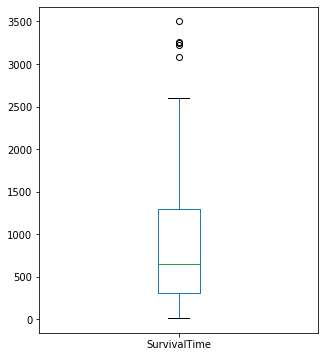

In [16]:
train_output[['SurvivalTime']].boxplot(grid = False, figsize = (5,6))

Now that the data exploration is finished let's move on to regrouping all the data.

In [17]:
df = train_clinical.join(normalized_train_radiomics)
df = df.join(train_output)
print(df.shape)
df.head()

(300, 59)


,Mstage,Nstage,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,...,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime,Event
0,0,0,2,66.0000,0.279967,0.171372,-0.427801,-0.401574,0.312424,-0.439710,...,-0.231863,0.867081,-0.171186,-0.268908,-0.157392,0.037123,-0.220072,-0.620421,1378.0,0.0
1,0,2,4,64.5722,-0.493821,-0.587190,0.337381,0.243189,-0.451910,0.009116,...,0.038241,-0.030272,-0.333507,0.107688,-0.358934,0.164666,-0.252541,-0.153327,379.0,1.0
2,0,3,2,66.0452,0.204689,0.091284,0.188850,-0.347201,0.240113,0.026316,...,-0.095638,-0.900271,-0.378659,-0.475541,-0.425581,-0.805669,-0.203033,0.074239,573.0,1.0
3,0,2,3,59.3566,0.118113,0.000854,-0.476864,-0.282723,0.156439,-0.549678,...,-0.447370,0.414517,-0.258350,-0.399018,-0.265421,-0.262222,-0.241803,-0.568461,959.0,0.0
4,0,3,4,71.0554,-0.384876,-0.489053,-0.280182,0.139337,-0.341289,-0.452020,...,-0.462300,-0.253248,0.217349,1.254858,0.044891,1.377164,0.533905,0.131265,2119.0,0.0


We finally get a dataset with 300 rows and 57 features (without counting the output features). The number of patients is indeed really small but that is one of the challenge to overcome.

# Model building

## Features

In [18]:
features = list(set(df.columns) - set(['SurvivalTime', 'Event']))
features

['original_shape_VoxelVolume',
 'original_glcm_JointEntropy',
 'original_glcm_ClusterProminence',
 'age',
 'original_shape_SurfaceArea',
 'original_glcm_ClusterTendency',
 'original_glcm_InverseVariance',
 'original_firstorder_Energy',
 'original_glcm_JointEnergy',
 'original_glrlm_GrayLevelNonUniformity',
 'original_shape_Compactness2',
 'original_firstorder_StandardDeviation',
 'original_glrlm_LongRunEmphasis',
 'original_shape_Compactness1',
 'original_glcm_ClusterShade',
 'original_firstorder_Entropy',
 'original_firstorder_Uniformity',
 'Tstage',
 'original_glcm_DifferenceAverage',
 'original_glrlm_ShortRunHighGrayLevelEmphasis',
 'Mstage',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'original_firstorder_Variance',
 'original_glcm_MaximumProbability',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glrlm_RunPercentage',
 'original_firstorder_Skewness',
 'original_glcm_DifferenceEntropy',
 'original_shape_Sphericity',
 'original_firstorder_Maximum',
 'origi

## Feature selection

The approach I first thought about was to remove features that have low variance since they may harm the convergence of our model. I tried doing this using __*VarianceThreshold*__ but wasn't very successfull in doing so (some features still troubled my model). I had about 35 features left and many were correlated to each other so the second step would've to filter some of them to improve the results. Here's a view of some of them.

### Collinearity

In [19]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[features], 10))

Top Absolute Correlations
original_glcm_Id                             original_glcm_Idm                            0.999539
original_shape_Compactness1                  original_shape_Sphericity                    0.998254
original_firstorder_Entropy                  original_glcm_SumEntropy                     0.995903
original_glcm_Autocorrelation                original_glrlm_HighGrayLevelRunEmphasis      0.992243
original_glrlm_ShortRunLowGrayLevelEmphasis  original_glrlm_LowGrayLevelRunEmphasis       0.990360
original_firstorder_StandardDeviation        original_firstorder_MeanAbsoluteDeviation    0.988645
original_glcm_Autocorrelation                original_glcm_SumAverage                     0.987396
original_shape_Compactness2                  original_shape_Compactness1                  0.987308
original_glcm_JointEntropy                   original_firstorder_Entropy                  0.987007
original_glrlm_RunPercentage                 original_glcm_Idm                     

### Correlation with the output

The second approach, the one I chose to follow in this study, was to keep only the features that were somehow correlated to the output variable. In doing so we get about 29 features (without counting *'Event'* and *'SurvivalTime'*).

In [20]:
cor = df.corr()
#Correlation with output variable
cor_target = abs(cor["SurvivalTime"])
#Selecting correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features = list(relevant_features.index)
relevant_features

['Nstage',
 'original_shape_Maximum3DDiameter',
 'original_shape_SurfaceVolumeRatio',
 'original_firstorder_Entropy',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Uniformity',
 'original_glcm_Autocorrelation',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceAverage',
 'original_glcm_JointEnergy',
 'original_glcm_JointEntropy',
 'original_glcm_Id',
 'original_glcm_Idm',
 'original_glcm_Imc1',
 'original_glcm_Idmn',
 'original_glcm_Idn',
 'original_glcm_InverseVariance',
 'original_glcm_MaximumProbability',
 'original_glcm_SumAverage',
 'original_glcm_SumEntropy',
 'original_glrlm_ShortRunEmphasis',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_RunPercentage',
 'original_glrlm_HighGrayLevelRunEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'SurvivalTime',
 'Event']

## Model : Cox proportional hazard (Cox-PH)

Now we create our model and fit it to the data.

In [21]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df[relevant_features], duration_col = 'SurvivalTime', event_col='Event')
cph.print_summary()

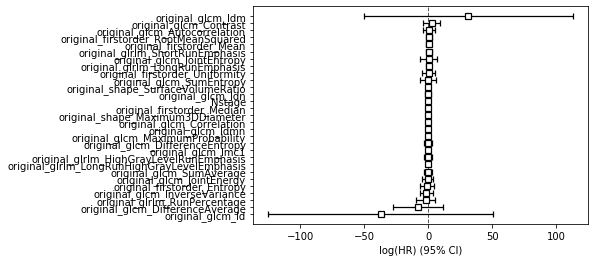

In [22]:
cph.plot()

## Hyperparameter tuning

We're going to try to improve our model by finding the best penalizer. Since I didn't manage to figure out how to use **GridSearch** with the Cox model, I just compared the models on the concordance computed and kept the best penalizer.

In [23]:
penalizers = np.logspace(0,4,10)
best_penalizer = 0
best_concordance = cph.score_
for penalizer in penalizers:
    cph_temp = CoxPHFitter(penalizer = penalizer)
    cph_temp.fit(df[relevant_features], duration_col = 'SurvivalTime', event_col='Event')
    if(cph_temp.score_ > best_concordance):
        best_concordance = cph_temp.score_
        best_penalizer = penalizer
print(best_penalizer, best_concordance)

0 0.7232238881508193


The best penalizer is 0.0 so there's nothing to change.

In [24]:
print("Model Concordance : ", round(best_concordance, 4))

Model Concordance :  0.7232


# Applying our model on the test set

The only thing left is to apply our model to predict the SurvivalTime of the test set patients. We don't forget to apply the same processing steps that we did for the training set.

In [33]:
test_clinical = pd.read_csv("data/test/features/clinical_data.csv")
test_clinical["age"].fillna(test_clinical["age"].mean(), inplace=True)

test_radiomics = pd.read_csv("data/test/features/radiomics.csv", dtype ='float64', skiprows = [0, 2], usecols = range(1,54))
normalized_test_radiomics = pd.DataFrame(scaler.transform(test_radiomics), columns = test_radiomics.columns)

df_test = test_clinical.join(normalized_test_radiomics)
patient = pd.DataFrame(patientID)
patient.columns = ['PatientID']
patient

df_test.drop(columns = ["Histology", "PatientID", "SourceDataset"], inplace = True)
df_test.head()

,Mstage,Nstage,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,0,0,4,44.3970,0.452504,0.360044,1.216854,-0.520641,0.476651,1.710172,...,1.226722,2.341417,1.403312,-1.455020,-0.426396,-0.668198,-0.508501,-1.119364,-0.096293,0.187727
1,0,3,1,63.3183,0.946349,0.939444,-1.266283,-0.824221,0.935891,-0.876144,...,-0.808292,-0.545309,-0.681403,1.312151,0.826507,-1.375678,0.984667,-1.214359,0.227976,-0.892849
2,0,2,2,64.7255,-1.625054,-1.438368,1.165523,1.734344,-1.674492,0.203588,...,0.469073,-0.109386,-0.250917,-0.902468,-0.466203,1.493599,-0.522382,1.315964,-0.276817,0.861445
3,0,0,2,65.3635,0.851114,0.823169,-0.472656,-0.769538,0.848513,-0.563652,...,-0.041963,-0.392401,-0.508740,-0.421059,-0.351022,1.308855,-0.384944,1.321783,-0.250449,0.220705
4,0,0,2,50.0000,-1.332325,-1.247471,-0.202770,1.255324,-1.343403,-0.288652,...,-0.792850,-0.459939,-0.188468,1.230154,1.768742,-1.934154,2.116660,-1.982086,0.570044,-0.957345


In [26]:
# Checking for NaN values just to be sure there's none
df_test.isnull().values.any()

False

## Prediction

In [40]:
feat = list(set(relevant_features) - set(['SurvivalTime', 'Event']))
prediction_result = cph.predict_expectation(df[feat])
prediction_result.columns = ['SurvivalTime']

prediction_result = patient.join(prediction_result)
prediction_result["Event"] = "nan"
prediction_result

,PatientID,SurvivalTime,Event
0,13,1856.842260,nan
1,155,1353.151901,nan
2,404,1292.913248,nan
3,407,1646.776843,nan
4,9,1162.439328,nan
...,...,...,...
120,66,1425.612497,nan
121,132,1268.944914,nan
122,169,1407.674163,nan
123,199,1202.173980,nan


In [41]:
prediction_result.to_csv(r'./predictions.csv', index = None, header=True)

# Conclusion

Through this study we managed to predict the remaining days to live using a set of pre-extracted features from a CT-scan. The model developed performs relatively well given the fact that the baseline proposed reaches a Concordance Index (CI) of 0.691 on the test set. However, the challenge mentions that several studies point out that hand-defined features such as the ones used here can be highly biased and suboptimal for various tasks. Moreover, the dataset of patients is very small which can add to the bias.  

Since the data of the patients is taken from 2 different datasets, one area of improvement would be to try to build 2 different models (one for each dataset) and then combine them together. More work can also be done to improve the features used to make a prediction.  

All in all the challenge was very interesting. It made me go beyond my academic knowledge of things, confronted me to new problems and made me discover an other aspect of machine learning. I learned a lot from this and it only affirmed my will of wanting to work in developing those kinds of solutions.